# Estimation with Small Samples

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1cpj2y9/q_few_samples_estimate_distribution_help/).

> Hey, so imagine I only have 6 samples from a value that has a normal distribution. Can I estimate the range of likely distributions from those 6?
>
> Let's be more specific. I'm considering the accuracy of a blood testing device. I took 6 samples of my blood at the same time from the same vein and gave them to the machine. The results are not all the same (as expected), indicating the device's inherent level of imprecision.
>
> So, I'm wondering if there's a way to estimate the range of possibilities of what I would see if I could give 100 or 1000 samples?
>
> I'm comfortable assuming a normal distribution around the "true" value. Is there any stats method to guesstimate the range of likely values for sigma? Or would I just need to drain my blood dry to get 1000 samples to figure that out?
>
> Fyi, not a statistician.

Because the sample size is so small, this question cries out for a Bayesian approach.
Why?

* Bayesian methods do a good job of taking advantage of background information and extracting as much information as possible from the data,

* With a small sample size, the uncertainty of the result is large, so it is important to quantify it, and

* The motivating question is explicitly about making probabilistic predictions, which is what Bayesian methods do and classical methods don't.

OP didn't respond to my questions about the context, so as an example, let's suppose the blood test is for LDL (low-density lipoprotein), also known as "bad cholesterol".

Assuming that the repeated measurements are made over the course of an hour or so, while fasting, we would not expect the true level to change much, so variation in the measurements would largely reflect the precision of the testing device.

With that assumption, let's see what we can do.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/gauss_bayes.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## Bayesian estimation

Let's suppose that the true level of LDL is 100 mg/dL, and the distribution of measurements is normally-distributed with mean `mu-0` and standard deviation `sigma=5`.
We can generate a hypothetical dataset like this.

In [3]:
np.random.seed(17)

mu_actual = 100
sigma_actual = 5
data = np.random.normal(mu_actual, sigma_actual, size=6)
data

array([101.38132945,  90.72685961, 103.11950556, 105.72655645,
       105.18595234, 109.43319465])

Now we need prior distributions for `mu` and `sigma`.
For the prior distribution of `mu` we could use the distribution of LDL levels in the general population.
Let's suppose that looks something like this.

In [4]:
from scipy.stats import norm

hyper_mu = 120
hyper_sigma = 40

mus = np.linspace(0, 240, 51)
ps = norm(hyper_mu, hyper_sigma).pdf(mus)

In [5]:
from empiricaldist import Pmf

prior_mu = Pmf(ps, mus)
prior_mu.index.name = 'mu'
prior_mu.normalize()

0.20787503382731912

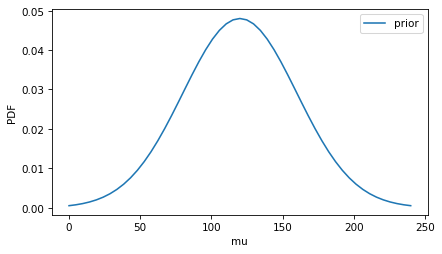

In [6]:
prior_mu.plot(label='prior')
decorate(ylabel='PDF')

For the prior distribution of `sigma`, we could use some background information about the device.
For example, based on similar devices, what values of `sigma` would be expected?

I'll use a gamma distribution to construct a prior PMF, but it could be anything.

In [7]:
from scipy.stats import invgamma

alpha = 1
beta = 3

variances = np.linspace(0.1, 400, 101)
sigmas = np.sqrt(variances)
ps = invgamma(alpha, loc=0, scale=beta).pdf(sigmas)

In [8]:
from scipy.stats import gamma

alpha = 2
beta = 3

sigmas = np.linspace(0.1, 20, 61)
ps = gamma(alpha, scale=beta).pdf(sigmas)

In [9]:
prior_sigma = Pmf(ps, sigmas)
prior_sigma.index.name = 'sigma'
prior_sigma.normalize()

2.9879152435447334

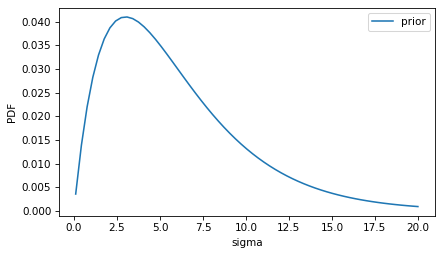

In [10]:
prior_sigma.plot(label='prior')
decorate(ylabel='PDF')

I'll use this function to make a Pandas DataFrame to represent the joint prior.

In [11]:
def make_joint(s1, s2):
    """Compute the outer product of two Series.

    First Series goes across the columns;
    second goes down the rows.

    s1: Series
    s2: Series

    return: DataFrame
    """
    X, Y = np.meshgrid(s1, s2, indexing='ij')
    return pd.DataFrame(X*Y, index=s1.index, columns=s2.index)

In [12]:
prior = make_joint(prior_mu, prior_sigma)
prior.shape

(51, 61)

I'll use the following function to make a contour plot of the prior.

In [13]:
def plot_contour(joint):
    """Plot a joint distribution.

    joint: DataFrame representing a joint PMF
    """
    low = joint.to_numpy().min()
    high = joint.to_numpy().max()
    levels = np.linspace(low, high, 6)
    levels = levels[1:]

    cs = plt.contour(joint.columns, joint.index, joint, levels=levels, linewidths=1)
    decorate(xlabel=joint.columns.name,
             ylabel=joint.index.name)
    return cs

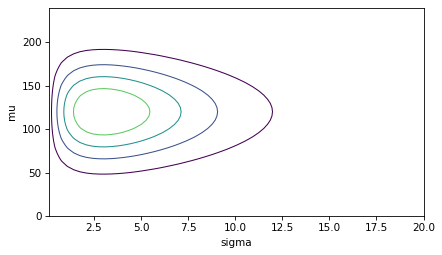

In [14]:
plot_contour(prior)
decorate()

## The update

To use the data to update the prior, we have to compute the likelihood of the data for each possible pair of `mu` and `sigma`.
Can can do that by creating a 3-D mesh with the possible values of `mu` and `sigma`, and the observed values of the data.

In [15]:
MU, SIGMA, DATA = np.meshgrid(prior_mu.index, prior_sigma.index, data,
                              indexing='ij')
MU.shape

(51, 61, 6)

Now we can evaluate the normal distribution for each data point and each pair of `mu` and `sigma`.

In [16]:
densities = norm(MU, SIGMA).pdf(DATA)
densities.shape

(51, 61, 6)

The likelihood of each pair is the product of the densities for the data points.

In [17]:
likelihood = densities.prod(axis=2)
likelihood.shape

(51, 61)

The unnormalized posterior is the product of the prior and the likelihood.

In [18]:
posterior = prior * likelihood

We can normalize it like this.

In [19]:
def normalize(joint):
    """Normalize a joint distribution.

    joint: DataFrame
    """
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

In [20]:
normalize(posterior)
posterior.shape

(51, 61)

And here's what the result looks like.

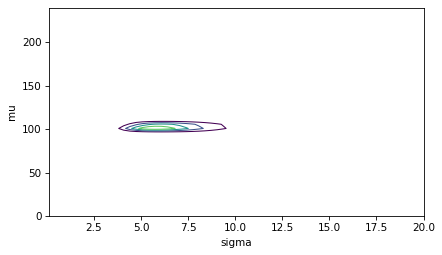

In [21]:
plot_contour(posterior)
decorate()

With only six data points, we have a lot of uncertainty about `sigma`.
Here's the posterior distribution of `sigma` compared to the prior.

In [22]:
def marginal(joint, axis):
    """Compute a marginal distribution.

    axis=0 returns the marginal distribution of the first variable
    axis=1 returns the marginal distribution of the second variable

    joint: DataFrame representing a joint distribution
    axis: int axis to sum along

    returns: Pmf
    """
    return Pmf(joint.sum(axis=axis))

In [23]:
posterior_sigma = marginal(posterior, 0)

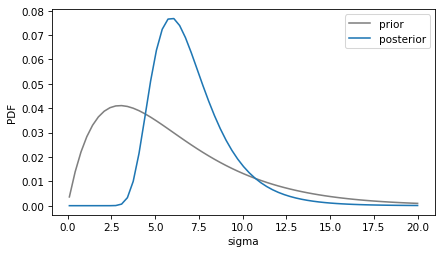

In [24]:
prior_sigma.plot(color='gray', label='prior')
posterior_sigma.plot(label='posterior')

decorate(xlabel='sigma', ylabel='PDF')

The posterior mean is about 7, somewhat higher than the actual value we used to generate the data.

In [25]:
posterior_sigma.mean()

7.044575750861707

## Predictions

The last part of OP's question is "So, I'm wondering if there's a way to estimate the range of possibilities of what I would see if I could give 100 or 1000 samples?"

We can simulate a future experiment with larger sample size by drawing random pairs from the joint posterior distribution and generating simulated measurements.

That's easier to do if we stack the posterior PMF.

In [26]:
posterior_pmf = Pmf(posterior.stack())
posterior_pmf.head()

mu   sigma   
0.0  0.100000    0.0
     0.431667    0.0
     0.763333    0.0
dtype: float64

Now we can use NumPy's choice function to choose a random pair of `mu` and `sigma`.
For each random pair, we can generate 1000 simulated measurements from a normal distribution, and plot the distribution of the results.

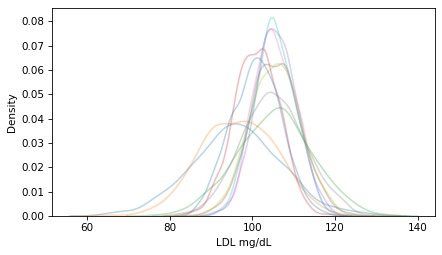

In [27]:
for i in range(11):
    mu, sigma = np.random.choice(posterior_pmf.index, p=posterior_pmf)
    sample = np.random.normal(mu, sigma, size=1000)
    sns.kdeplot(sample, alpha=0.3)
    
decorate(xlabel='LDL mg/dL')

Each line shows the distribution of a possible sample of 1000 measurements. You can see that the vary in both location and spread, due to the uncertainty represented by the posterior distribution.

## Discussion

Choice of prior

Bayesian grid methods are great -- it's a shame they are not more widely known and used.

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)